In [2]:
import sys
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

sys.path.insert(0, "../../python")
from common import *

In [4]:
model = LoadModel('../../../../output/networks/2017v2p6/DeepTau2017v2p6_step1_e2.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [8]:
plot_model(model, to_file='model.png', show_shapes=True)

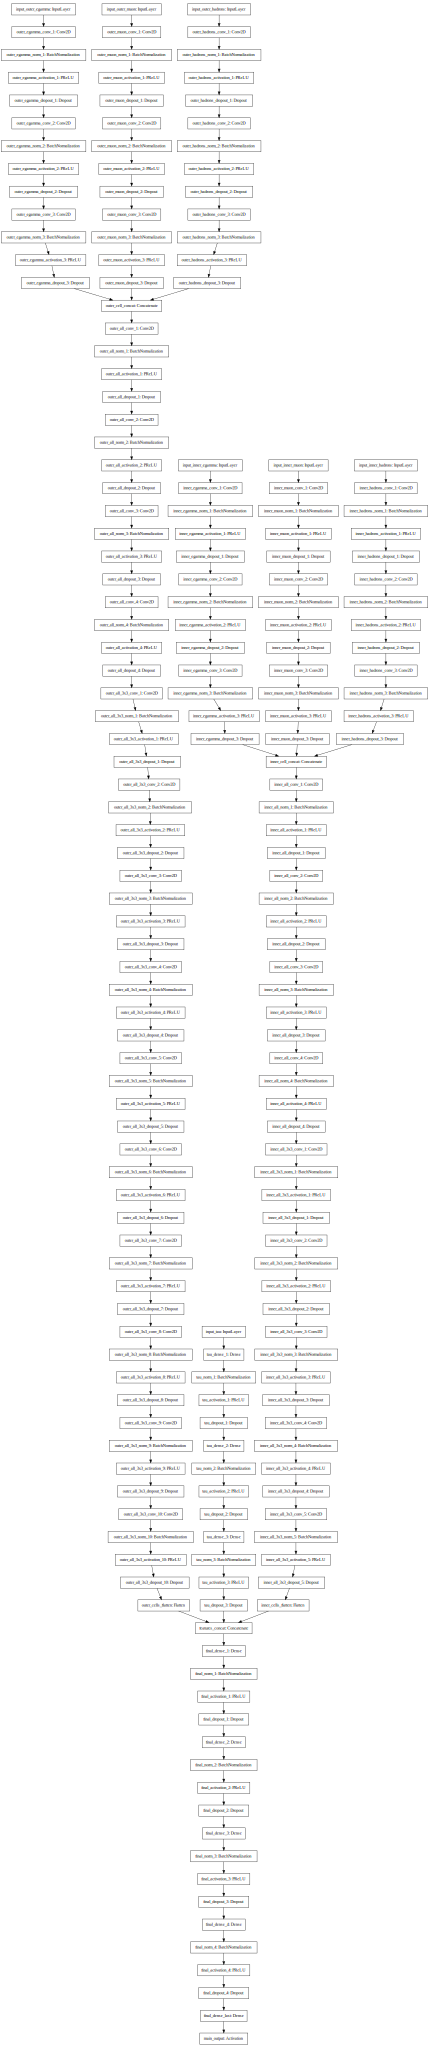

In [5]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [6]:
plot = model_to_dot(model).create(prog='dot', format='svg')

In [11]:
plot = model_to_dot(model, show_shapes=True)

In [12]:
plot.write_svg('model.svg')

In [2]:
n_hidden_layers = 20
n_neurons = 1024
input_shape=(129,)
n_outputs=4
model_name = "{}L{}N".format(n_hidden_layers, n_neurons)
model = Sequential()
model.add(Dense(n_neurons, input_shape=input_shape, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
for n in range(n_hidden_layers):
    model.add(Dense(n_neurons, kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
model.add(Dense(n_outputs))
model.add(Activation("softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              133120    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
__________

In [3]:
21172228 / 791617

26.745544878394476